# Neural coding in barrel cortex during whisker-guided locomotion

### Analysis of tabluar data from ephys experiments

This notebook loads and plots and tables derived from the electrophysiology data found in Sofroniew\*, Vlasov\*, et al. (submitted) and will reproduce figure 4 panels d-i, figure 5 b-e, figure S2 c-i, figure S3, S4, S5.

## Setup evnironment

In [1]:
import os
import numpy as np
import pandas as pd
import json
import requests
from scipy import stats

## Setup plotting

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')
from helper.plots import *

####Widgets

In [3]:
from IPython.html import widgets
from IPython.display import display
from IPython.html.widgets import interactive
from IPython.html.widgets import interact

/Users/choldgraf/anaconda/envs/elife/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
def listSources(animal):
    sourcesList = table.index.tolist()
    sources.options = ['%.0f' % x[1] for x in sourcesList if x[0] == animal]

## Helper functions for loading and processing data

This helper function is using during loading to align tables to a primary key

In [5]:
def align(table, primary, index):
    table['sourceId'] = primary['sourceId']
    table.set_index(index,inplace = True)
    table.columns = table.columns.astype('float')
    return table

This helper function loads mutliple tables from a session into a dictionary where the keys are table names

In [6]:
def load(session, tables):
    # load the info
    r = requests.get(path + session + '/info.json').content
    info = json.loads(r)
        
    # load the units (which have our primary keys)
    units = pd.DataFrame.from_csv(path + session + '/tables/units.csv')
    
    # load all the tables
    d = {n : pd.DataFrame.from_csv(path + session + '/tables/%s.csv' % n) for n in tables}
    
    # align the tables (specify each manually because different tables use different keys)
    d['waveforms'] = align(d['waveforms'], units, 'sourceId')
    d['profile'] = align(d['profile'], units, 'sourceId')
    xs, ys = smoothfit(d['profile'].columns.values, d['profile'].values[0],smooth=smooth, res=1000)
    smoothed = [smoothfit(d['profile'].columns.values, y, smooth=smooth,res=1000)[1] for y in d['profile'].values]
    d['profile'] = pd.DataFrame(smoothed, index=d['profile'].index, columns=xs)

    d['tuning'] = align(d['tuning'], units, ['sourceId', 'label'])
    d['tuningNum'] = d['tuning'].xs('numTrials', level='label')
    err = d['tuning'].xs('stdRate', level='label').divide(d['tuningNum'].apply(np.sqrt))
    d['tuning'] = d['tuning'].xs('meanRate', level='label')
    d['tuningErr'] = err
    d['tuningSummary'] = summarizeTuning(d['tuning'],-1)
    d['ISI'] = align(d['ISI'], units, 'sourceId')
    d['profileSummary'] = summarizeProfile(d['profile'])
    
    d['tuningSpeed'] = pd.DataFrame.from_csv(path + session + '/tables/tuning-speed.csv')
    d['tuningSpeed'] = align(d['tuningSpeed'], units, ['sourceId', 'label'])
    d['tuningSpeedNum'] = d['tuningSpeed'].xs('numTrials', level='label')
    err = d['tuningSpeed'].xs('stdRate', level='label').divide(d['tuningSpeedNum'].apply(np.sqrt))
    d['tuningSpeed'] = d['tuningSpeed'].xs('meanRate', level='label')
    d['tuningSpeedErr'] = err
    d['tuningSpeedSummary'] = summarizeTuning(d['tuningSpeed'],0)
    
    if info['clAnm']:
        d['tuningClosed'] = pd.DataFrame.from_csv(path + session + '/tables/tuning-closed.csv')
        d['tuningClosed'] = align(d['tuningClosed'], units, ['sourceId', 'label'])
        d['tuningClosedNum'] = d['tuningClosed'].xs('numTrials', level='label')
        err = d['tuningClosed'].xs('stdRate', level='label').divide(d['tuningClosedNum'].apply(np.sqrt))
        d['tuningClosed'] = d['tuningClosed'].xs('meanRate', level='label')
        d['tuningClosedErr'] = err
        d['tuningClosedSummary'] = summarizeTuning(d['tuningClosed'],-1)
    if info['ipsiAnm']:
        d['tuningIpsi'] = pd.DataFrame.from_csv(path + session + '/tables/tuning-ipsi.csv')
        d['tuningIpsi'] = align(d['tuningIpsi'], units, ['sourceId', 'label'])
        d['tuningIpsiNum'] = d['tuningIpsi'].xs('numTrials', level='label')
        err = d['tuningIpsi'].xs('stdRate', level='label').divide(d['tuningIpsiNum'].apply(np.sqrt))
        d['tuningIpsi'] = d['tuningIpsi'].xs('meanRate', level='label')
        d['tuningIpsiErr'] = err
        d['tuningIpsiSummary'] = summarizeTuning(d['tuningIpsi'],-1)

    # assign the index
    units.set_index('sourceId',inplace = True)
    
    # classify units
    units['clean'] = classifyUnits(units)
    
    # add tables
    d['units'] = units
    d = pd.concat([d[x] for x in d.keys()], axis = 1, keys = d.keys())
    
    info['contributors'] = ', '.join(info['contributors'])
    info['session'] = session
    info = pd.DataFrame(info, index = [str(info['id'])])
    
    #d['info'] = info
    return d, info

#### Append position tuning information to units data frame

In [7]:
def summarizeTuning(df,index):
    x = df.columns.values
    xs, ys = smoothfit(x, df.values[0],smooth=smooth)
    smoothed = [smoothfit(x, y, smooth=smooth)[1] for y in df.values]

    summary = pd.DataFrame(index=df.index)
    summary['Baseline'] = [y[index] for y in smoothed]
    summary['Max'] = [max(y) for y in smoothed]
    summary['ArgMax'] = [xs[np.argmax(y)] for y in smoothed]
    summary['Min'] = [min(y) for y in smoothed]
    summary['ArgMin'] = [xs[np.argmin(y)] for y in smoothed]
    summary['Mean'] = [np.mean(y) for y in smoothed]

    summary['Activation'] = summary.Max - summary.Baseline
    summary['Supression'] = summary.Baseline - summary.Min
    summary['Range'] = summary.Max - summary.Min
    
    #summary['ModulationOn'] = (summary.Max - summary.Baseline)/(summary.Baseline + summary.Max)
    #summary['ModulationOff'] = (summary.Min - summary.Baseline)/(summary.Baseline + summary.Min)
    #summary['Modulation'] = summary['ModulationOn']
    #summary['Modulation'][summary['Activation']<=summary['Supression']] = summary['ModulationOff'][summary['Activation']<=summary['Supression']]
    #summary['Simplicity'] = (summary.Activation - summary.Supression)/(summary.Activation + summary.Supression)
    summary['Modulation'] = (summary.Activation - summary.Supression)/(summary.Activation + summary.Supression)
    
    summary['TotalModulation'] = (summary.Max - summary.Min)/(summary.Max + summary.Min)
    return summary

#### Append direction tuning information to units data frame

In [8]:
def summarizeProfile(df):
    x = df.columns.values
    summary = pd.DataFrame(index=df.index)
    summary['TowardsMod'] = [max(y[:500])-min(y[:500]) for y in df.values]
    summary['AwayMod'] = [max(y[-500:])-min(y[-500:]) for y in df.values]
    summary['Modulation'] = (summary.TowardsMod - summary.AwayMod)/(summary.TowardsMod + summary.AwayMod)

    summary['Max'] = [max(y) for y in df.values]
    summary['ArgMax'] = [x[np.argmax(y)] for y in df.values]
    summary['ArgMaxTowards'] = [x[np.argmax(y[:500])] for y in df.values]
    return summary

#### Classify units as clean or not

In [9]:
def classifyUnits(df):
    goodWaveformSNR = df.waveformSNR > 6
    goodISI = df.rateFA  < 1.5
    goodStability = (df.spkAmpDrift.abs() < 150) & (df.firingDrift.abs() < 175)
    clean = goodWaveformSNR & goodISI & goodStability
    return clean

#### Normalize spike waveforms

In [10]:
def normalize(waves):
    wavesNorm = [np.divide(x - np.mean(x),np.std(x)) for x in waves]
    return wavesNorm

#### Define smooth parameter

In [11]:
smooth = 1

## Create helper functions for plotting 

Define colors

In [12]:
fs = [.95, .63, .77]
frs = [.3, .3, .3]
rs = [.56, .45, .70]

## Load JSON + CSV as DataFrames

#### Specify location of the data

In [13]:
path = 'https://s3.amazonaws.com/neuro.datasets/svoboda.lab/tactile.coding/'

#### Load the tables from each session

In [14]:
sessions = range(0,13)
tables = ['units', 'ISI', 'waveforms', 'tuning', 'profile']
data = [load('%02g' % s, tables) for s in sessions]
table =  pd.concat([x[0] for x in data], keys=[str(x[1].index[0]) for x in data], names=['anmId'])
info =  pd.concat([x[1] for x in data])

#### Create widgets to allow for animal selection

In [15]:
animals = widgets.Dropdown(options = info.index.tolist())
wA = interactive(listSources, animal=animals)
sources = widgets.Select(options = [])
wS = interactive(lambda source:source, source=sources)

## Plot location of recordings

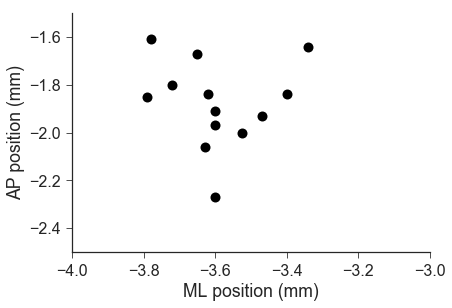

In [16]:
plt.plot(info.cordsML,info.cordsAP,'.', color='k', ms=20);
plt.ylim([-2.5, -1.5])
plt.xlim([-4.0, -3.0])
plt.xlabel('ML position (mm)')
plt.ylabel('AP position (mm)')
sns.despine()

## Summarize units

#### Plot waveform SNR vs False Alarm Rate

/Users/choldgraf/anaconda/envs/elife/lib/python2.7/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/choldgraf/anaconda/envs/elife/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


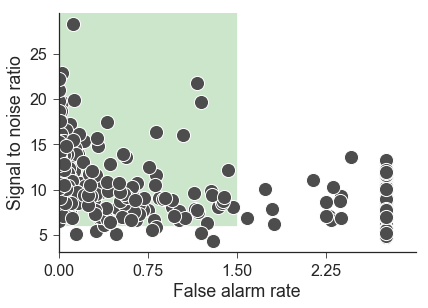

In [17]:
x = table.units.rateFA
x[x>2.5] = 2.75;
y = table.units.waveformSNR
scatter(x, y, xlabel='False alarm rate', ylabel='Signal to noise ratio');
plt.xticks(np.linspace(0,2.25,4));
#plt.plot([1.5, 1.5], [6, 30], color=[0,0.6,0], zorder=1)
#plt.plot([0, 1.5], [6, 6], color=[0,0.6,0], zorder=1)
plt.fill([0, 1.5, 1.5, 0], [6, 6, 30, 30], edgecolor=[0.8,0.9,0.8], facecolor=[0.8,0.9,0.8]);
plt.xlim([0, 3]);

#### Take only clean units

In [18]:
table = table[table.units.clean]
print len(table)

209


In [19]:
goodTuning = table.units.pVal < 0.05
table = table[goodTuning]

#### Summarize clean units

In [20]:
units = table.units.reset_index()
print len(units)
unitCount = units.groupby(['anmId']).count()['sourceId'].values
print np.mean(unitCount), np.std(unitCount), len(unitCount)

179
13.7692307692 6.22839460923 13


## Plot spike summary information

#### Plot example mean waveform

In [21]:
animals.options = info.index.tolist()
display(wA,wS)

Widget Javascript not detected.  It may not be installed or enabled properly.


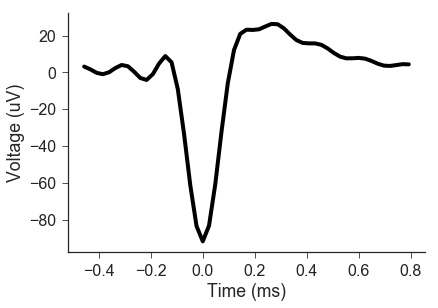

In [22]:
a = wA.kwargs['animal']
u = int(wS.kwargs['source'])
x = table.waveforms.columns
y = table.waveforms.loc[a,u].values
time(x, y)
plt.xlabel('Time (ms)');
plt.ylabel('Voltage (uV)');

#### Plot distribution of spike widths

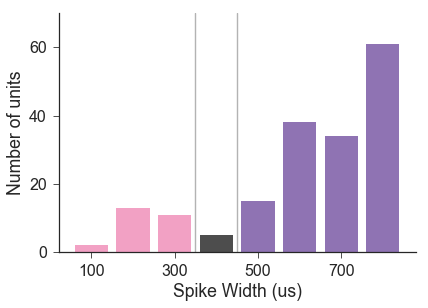

In [23]:
bins=range(50,950,100)
out = plt.hist(table.units.spkWidth, bins=bins, rwidth=0.8, color=[0.7,0.7,0.7], edgecolor='none');
plt.xlabel('Spike Width (us)')
plt.ylabel('Number of units')
col = [fs,fs,fs,frs,rs,rs,rs,rs]
for c, p in zip(col, out[2]):
    plt.setp(p, 'facecolor', c)
plt.plot([350, 350], [0, 70], color=[0.7,0.7,0.7], zorder=1)
plt.plot([450, 450], [0, 70], color=[0.7,0.7,0.7], zorder=1)
plt.ylim([0, 70])
plt.yticks(range(0,65,20))
plt.xticks(range(100,800,200))
sns.despine()

#### Plot waveforms across cell types

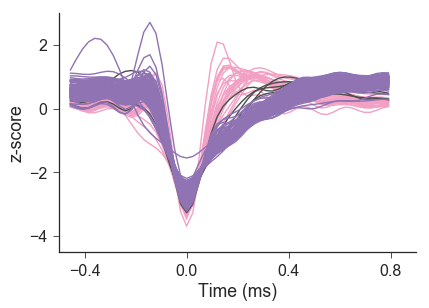

In [24]:
waves = table.waveforms[table.units.cellType == 'FastSpiker']
wavesNorm = normalize(waves.values)
for iSource in range(0,len(waves)):
    plt.plot(waves.columns.values,wavesNorm[iSource],color = fs);
waves = table.waveforms[table.units.cellType == 'IntermediateSpiker']
wavesNorm = normalize(waves.values)
for iSource in range(0,len(waves)):
    plt.plot(waves.columns.values,wavesNorm[iSource],color = frs);
waves = table.waveforms[table.units.cellType == 'RegularSpiker']
wavesNorm = normalize(waves.values)
for iSource in range(0,len(waves)):
    plt.plot(waves.columns.values,wavesNorm[iSource],color = rs);
sns.despine()
plt.xlabel('Time (ms)');
plt.ylabel('z-score');
plt.yticks(range(-4,3,2))
plt.ylim([-4.5, 3])
plt.xticks(np.linspace(-0.4,.8,4))
plt.xlim([-.5, .9]);

#### Plot example ISI

The paper includes the following ISI plots
* 'Anm_0235585', 9
* 'Anm_0250492', 28
* 'Anm_0256043', 0
* 'Anm_0237723', 0
* 'Anm_0237723', 27
* 'Anm_0250492', 0
* 'Anm_0250495', 8
* 'Anm_0235585', 12
* 'Anm_0245918', 15
* 'Anm_0237723', 2
* 'Anm_0235585', 2
* 'Anm_0245918', 2

In [25]:
animals.options = info.index.tolist()
display(wA,wS)

Widget Javascript not detected.  It may not be installed or enabled properly.


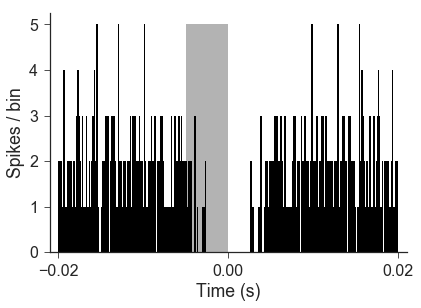

In [26]:
a = wA.kwargs['animal']
u = int(wS.kwargs['source'])
x = table.ISI.columns
y = table.ISI.loc[a, u]
plt.bar(-.0025, max(y), width=.005, linewidth=0, color=[.7, .7, .7]);
plt.bar(x, y, width=.0002, linewidth=0, color='k');
plt.xticks(np.linspace(-.02,.02,3))
plt.xlim([-.021, 0.021])
plt.xlabel('Time (s)');
plt.ylabel('Spikes / bin');
sns.despine()

## Extract units for tuning analysis

In [27]:
tableFS = table[table.units.cellType == 'FastSpiker']
table = table[table.units.cellType == 'RegularSpiker']
print len(table)

148


#FIGURE 3

## Plot tuning curves

The paper includes the following tuning curves
* 'Anm_0235585', 9
* 'Anm_0250492', 28
* 'Anm_0256043', 0
* 'Anm_0237723', 0
* 'Anm_0237723', 27
* 'Anm_0250492', 0
* 'Anm_0250495', 8
* 'Anm_0256043', 0
* 'Anm_0256043', 10

In [28]:
animals.options = info.index.tolist()
display(wA,wS)

Widget Javascript not detected.  It may not be installed or enabled properly.


1.00


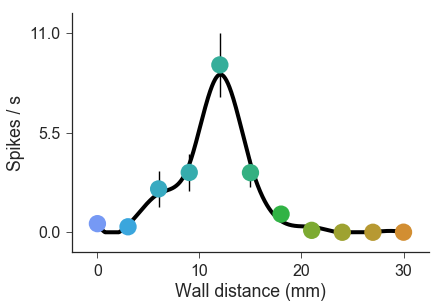

In [29]:
a = wA.kwargs['animal']
u = float(wS.kwargs['source'])
x = table.tuning.columns.values
y = table.tuning.loc[a,u].values
err = table.tuningErr.loc[a,u].values
rng = tuning(x, y, err, smooth=smooth, ylabel='Spikes / s');
print '%.2f' % table.tuningSummary.Modulation.loc[a,u]

#### Plot ipsi tuning curve

The paper includes the following ipsilateral tuning curves
* 'Anm_0250492', 0
* 'Anm_0250495', 8

In [30]:
animals.options = info[info.ipsiAnm.values == True].index.tolist()
display(wA,wS)

Widget Javascript not detected.  It may not be installed or enabled properly.


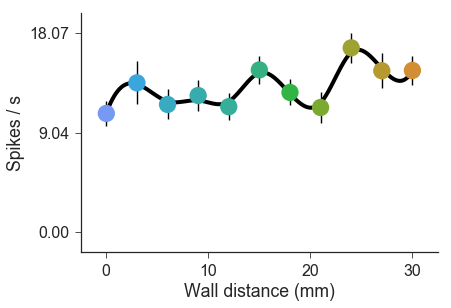

In [31]:
a = wA.kwargs['animal']
u = float(wS.kwargs['source'])  
x = table.tuningIpsi.columns.values
y = table.tuningIpsi.loc[a,u].values
err = table.tuningIpsiErr.loc[a,u].values
tuning(x, y, err, smooth=smooth, ylabel='Spikes / s');

#### Plot closed-loop tuning curve

The paper includes the following closed-loop tuning curves
* 'Anm_0250492', 0
* 'Anm_0250495', 8

In [32]:
animals.options = info[info.clAnm.values == True].index.tolist()
display(wA,wS)

Widget Javascript not detected.  It may not be installed or enabled properly.


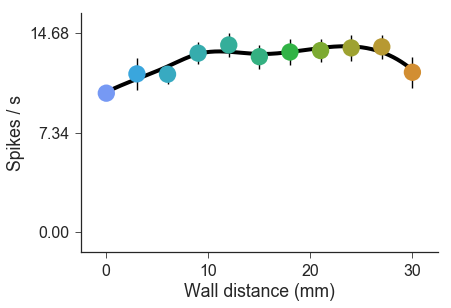

In [33]:
a = wA.kwargs['animal']
u = float(wS.kwargs['source'])
x = table.tuningClosed.columns.values[:11]
y = table.tuningClosed.loc[a,u].values[:11]
err = table.tuningClosedErr.loc[a,u].values[:11]
tuning(x, y, err, smooth=smooth, ylabel='Spikes / s');

#### Plot speed tuning curves

The paper includes the following closed-loop tuning curves
* 'Anm_0245918', 4
* 'Anm_0235585', 10
* 'Anm_0235585', 27
* 'Anm_0245918', 9

In [34]:
animals.options = info.index.tolist()
display(wA,wS)

Widget Javascript not detected.  It may not be installed or enabled properly.


1.00


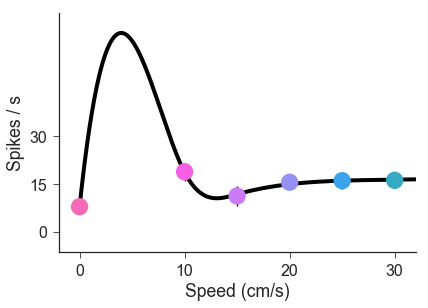

In [35]:
a = wA.kwargs['animal']
u = float(wS.kwargs['source'])
x = table.tuningSpeed.columns.values
y = table.tuningSpeed.loc[a,u].values
err = table.tuningSpeedErr.loc[a,u].values
x = x[~np.isnan(y)]
err = err[~np.isnan(y)]
y = y[~np.isnan(y)]
pal = sns.color_palette("husl", n_colors=len(x) + 6)
pal = pal[6:6+len(x)][::-1]
rng = tuning(x, y, err, smooth=smooth, pal=pal, ylabel='Spikes / s', label = 'Speed (cm/s)');
print '%.2f' % table.tuningSpeedSummary.Modulation.loc[a,u]
plt.xlim([-2, 32]);
plt.yticks([0, 15, 30]);

### Plot scatter of supression vs activation

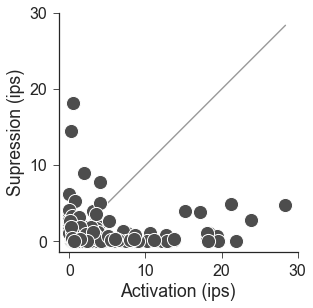

In [36]:
x = table.tuningSummary.Activation
y = table.tuningSummary.Supression
scatter(x, y, equal=True, xlabel='Activation (ips)', ylabel='Supression (ips)')
plt.yticks([0, 10, 20, 30]);
plt.xticks([0, 10, 20, 30]);

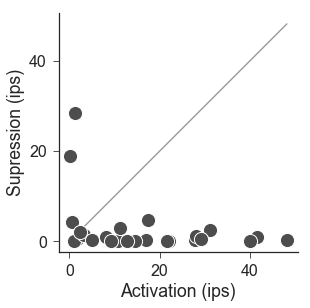

In [37]:
x = tableFS.tuningSummary.Activation
y = tableFS.tuningSummary.Supression
scatter(x, y, equal=True, xlabel='Activation (ips)', ylabel='Supression (ips)')
plt.yticks([0, 20, 40]);
plt.xticks([0, 20, 40]);

### Plot summary tuning curves

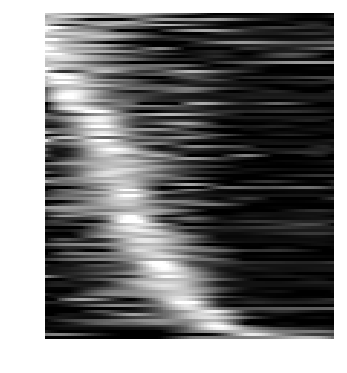

In [38]:
curves = table.sort_values([('tuningSummary','ArgMax')])
curves = curves[curves.tuningSummary.Activation>1]
xy = [(curves.tuning.columns.values, y) for y in curves.tuning.values]
fits = smootharray(xy, smooth=0, res=100)
fits = stats.zscore(fits, axis=1)
heatmap(fits, aspect=1, vmin=-1, vmax=2.5)

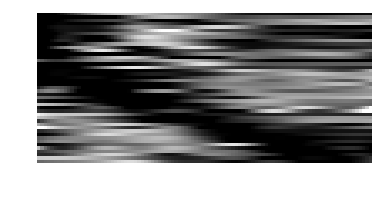

In [39]:
curves = table.sort_values([('tuningSummary','ArgMin')])
curves = curves[curves.tuningSummary.Supression>1]
xy = [(curves.tuning.columns.values, y) for y in curves.tuning.values]
fits = smootharray(xy, smooth=0, res=100)
fits = stats.zscore(fits, axis=1)
heatmap(fits, aspect=1, vmin=-1, vmax=2.5)

### Plot histogram of modulation

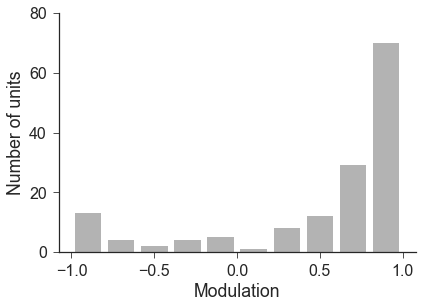

In [40]:
hist(table.tuningSummary.Modulation, xlabel='Modulation', ylabel='Number of units')
plt.yticks(np.linspace(0,80,5));

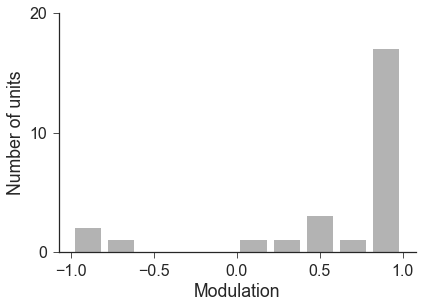

In [41]:
hist(tableFS.tuningSummary.Modulation, xlabel='Modulation', ylabel='Number of units')
plt.yticks(np.linspace(0,20,3));

### Plot histogram of modulation

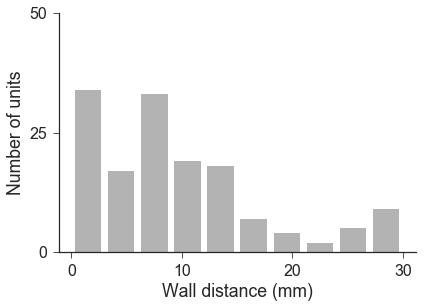

In [42]:
hist(table.tuningSummary.ArgMax, xlabel='Wall distance (mm)', ylabel='Number of units')
plt.yticks(np.linspace(0,50,3));
plt.xticks(np.linspace(0,30,4));

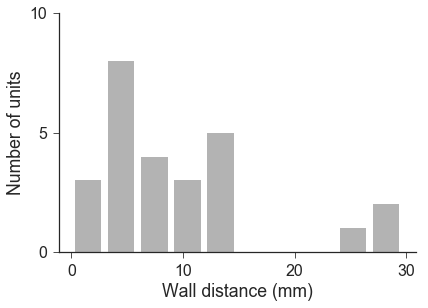

In [43]:
hist(tableFS.tuningSummary.ArgMax, xlabel='Wall distance (mm)', ylabel='Number of units')
plt.yticks(np.linspace(0,10,3));
plt.xticks(np.linspace(0,30,4));

### Plot scatter of wall modulation across layer 4 distance

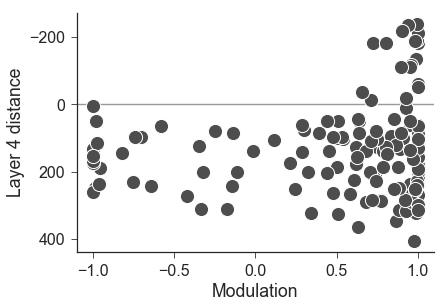

In [44]:
x = table.tuningSummary.Modulation
y = table.units.distLayer4
scatter(x, y, xlabel='Modulation', ylabel='Layer 4 distance', yinvert=True)
plt.yticks(np.linspace(-200,400,4));
plt.plot([-1.1, 1.1], [0, 0], color=[0.6, 0.6, 0.6], zorder=1);

#### Plot scatter of wall out of reach activity across layer 4 distance

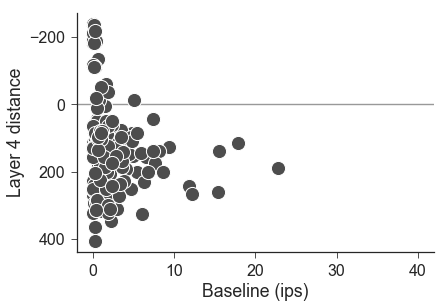

In [45]:
x = table.tuningSummary.Baseline
y = table.units.distLayer4
scatter(x, y, yinvert=True, xlabel='Baseline (ips)', ylabel='Layer 4 distance')
plt.plot([-2, 42], [0, 0], color=[0.6, 0.6, 0.6], zorder=1);
plt.xlim([-2, 42])
plt.yticks(np.linspace(-200,400,4));

#### Plot scatter of peak wall distance activity across layer 4 distance

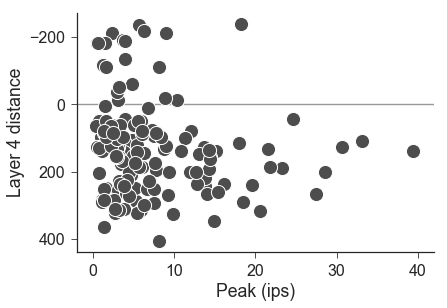

In [46]:
x = table.tuningSummary.Max
y = table.units.distLayer4
scatter(x, y, xlabel='Peak (ips)', ylabel='Layer 4 distance', yinvert=True)
plt.xlim([-2, 42])
plt.plot([-2, 42], [0, 0], color=[0.6, 0.6, 0.6], zorder=1);
plt.yticks(np.linspace(-200,400,4));

## Plot profiles

The paper includes the following time profiles
* 'Anm_0235585', 12
* 'Anm_0245918', 15
* 'Anm_0237723', 2
* 'Anm_0235585', 2

In [47]:
animals.options = info.index.tolist()
display(wA,wS)

Widget Javascript not detected.  It may not be installed or enabled properly.


0.18


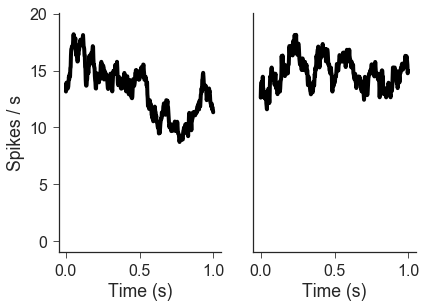

In [48]:
a = wA.kwargs['animal']
u = float(wS.kwargs['source'])
x1 = table.profile.columns.values[:500]
x1 = x1 - x1[0]
y1 = table.profile.loc[a, u].values[:500]
x2 = table.profile.columns.values[500:]
x2 = x2 - x2[0]
y2 = table.profile.loc[a, u].values[500:]
pairedtime(x1, y1, x2, y2);
print '%.2f' % table.profileSummary.Modulation.loc[a,u]

##Plot heatmap profiles

#### Plot symmetric units

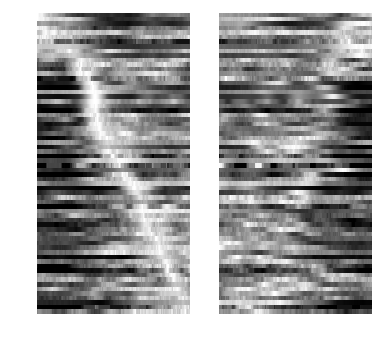

In [49]:
curves = table.sort_values([('profileSummary','ArgMaxTowards')])
curves = curves[curves.profileSummary.Modulation.abs()<=0.2]
vals1 = np.asarray([x[:500] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
vals2 = np.asarray([x[500:] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
pairedheatmap(vals1, vals2, aspect=15)

#### Plot asymmetric units

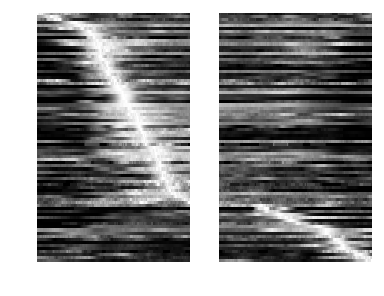

In [50]:
curves = table.sort_values([('profileSummary','ArgMax')])
curves = curves[curves.profileSummary.Modulation.abs()>0.2]
vals1 = np.asarray([x[:500] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
vals2 = np.asarray([x[500:] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
pairedheatmap(vals1, vals2, aspect=10)

## Plot summary data

#### Plot scatter of supression vs activation

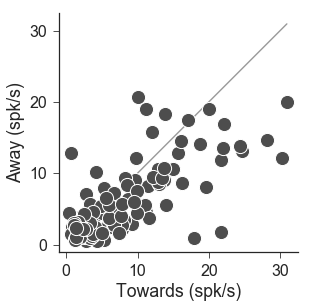

In [51]:
x = table.profileSummary.TowardsMod
y = table.profileSummary.AwayMod
scatter(x, y, equal=True, xlabel='Towards (spk/s)', ylabel='Away (spk/s)')
plt.yticks([0, 10, 20, 30]);
plt.xticks([0, 10, 20, 30]);

#### Plot histogram of modulation

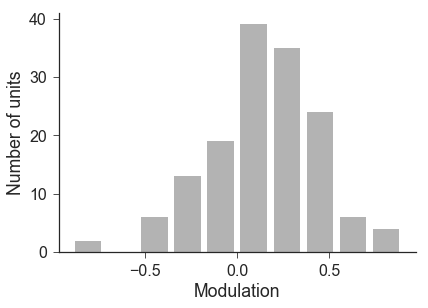

In [52]:
hist(table.profileSummary.Modulation, xlabel='Modulation', ylabel='Number of units')
plt.yticks(range(0,50,10));

#### Plot scatter of wall modulation across layer 4 distance

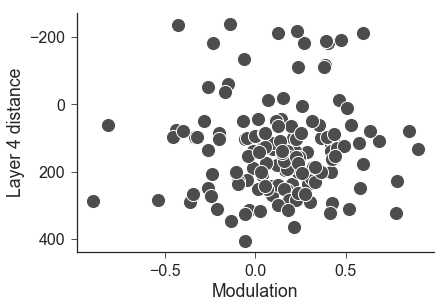

In [53]:
x = table.profileSummary.Modulation
y = table.units.distLayer4
scatter(x, y, xlabel='Modulation', ylabel='Layer 4 distance', yinvert=True)
plt.yticks(np.linspace(-200,400,4));

### Ipsi vs contra summary

0.979808875864
0.835777827219


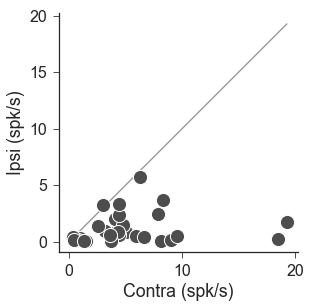

In [54]:
x = table[~table.units.pValIpsi.isnull()].tuningSummary.Range
y = table[~table.units.pValIpsi.isnull()].tuningIpsiSummary.Range
modLat = np.divide(x-y,x+y)
print modLat['Anm_0250492', 0.]
print modLat['Anm_0250492', 8.]
scatter(x, y, equal=True, xlabel='Contra (spk/s)', ylabel='Ipsi (spk/s)')

#### Histogram of ipsi vs contra modulation

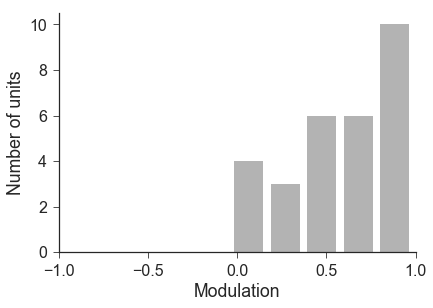

In [55]:
hist(modLat, bins=5, xlabel='Modulation', ylabel='Number of units')
plt.xlim([-1, 1]);

### Open loop vs closed loop summary

/Users/choldgraf/anaconda/envs/elife/lib/python2.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 114 but corresponding boolean dimension is 148
  """
/Users/choldgraf/anaconda/envs/elife/lib/python2.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 114 but corresponding boolean dimension is 148
  


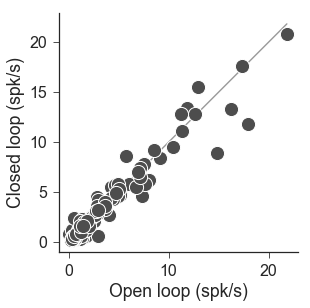

In [56]:
frac = table[~table.units.pValClosed.isnull()].tuningClosedNum.divide(table.tuningClosedNum.sum(axis=1),axis=0)<.02
vals = table[~table.units.pValClosed.isnull()].tuningClosed.values
vals = vals[:,:11]
frac = frac.values[:,:11]
vals[frac] = np.nan
x = np.nanmean(vals, axis=1)
vals = table[~table.units.pValClosed.isnull()].tuning.values
vals[frac] = np.nan
y = np.nanmean(vals, axis=1)
modLoop = np.divide(x-y,x+y)
scatter(x, y, equal=True, xlabel='Open loop (spk/s)', ylabel='Closed loop (spk/s)')

#### Histogram of open vs closed loop modulation

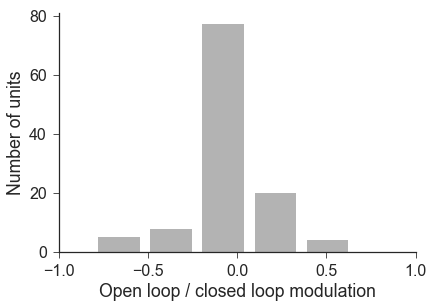

In [57]:
hist(modLoop, bins=5, xlabel='Open loop / closed loop modulation', ylabel='Number of units')
plt.xlim([-1, 1]);
plt.yticks(range(0,100,20));

### Depth of units recorded

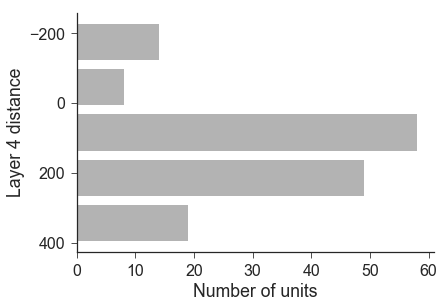

In [58]:
vals = table.units.distLayer4
hist(vals, bins=5, horizontal=True, xlabel='Number of units', ylabel='Layer 4 distance', yinvert=True)
plt.yticks(np.linspace(-200,400,4));

## Speed tuning

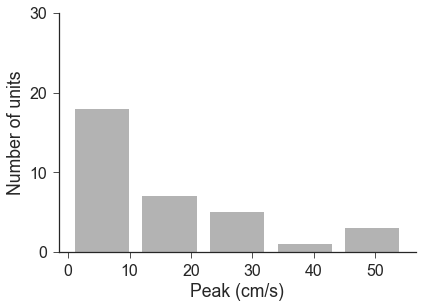

In [59]:
x = table[(table.units.pValSpeed < .05) & (table.tuningSpeedSummary.Range > 1)].tuningSpeedSummary.ArgMax
hist(x, bins=5, xlabel='Peak (cm/s)', ylabel='Number of units')
plt.yticks(range(0,40,10));

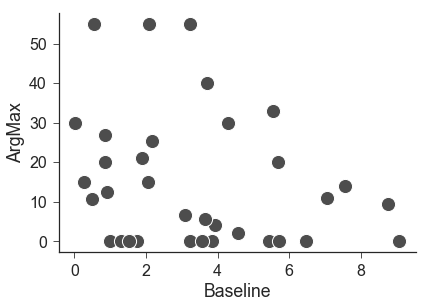

In [60]:
x = table[(table.units.pValSpeed < .05) & (table.tuningSpeedSummary.Range > 1)].tuningSpeedSummary.Baseline
y = table[(table.units.pValSpeed < .05) & (table.tuningSpeedSummary.Range > 1)].tuningSpeedSummary.ArgMax
scatter(x, y, xlabel='Baseline', ylabel='ArgMax');

In [61]:
print len(table)
print sum(table.units.pValSpeed < .05)
print sum(table.units.pValSpeed < .05).astype('float64')/len(table)

148
46
0.310810810811
